# Introduction to neural networks

A _neural network_ is a network of interconnected _artificial neurons_. The performance of a neural network is determined in equal parts by the type of processing occurring within each neuron and the network structure.

In this code, we will be using two important Python packages, `numpy` for numerical computations and linear algebra, and `matplotlib` for fast visualization.


In [2]:
import math                      # Math    
import numpy as np               # Fast math and arrays
import matplotlib.pyplot as plt  # Visualization
import matplotlib.colors as colors  # colors
import matplotlib.cm as cmx  # Colormaps
import pandas as pd

# The McCulloch-Pitts neuron

In the simplest McCulloch-Pitts model, a neuron is charactrized by an _activation function_ $f(x)$, which calculates the response of a neuron $i$ in terms of its summed inputs and an internal threshold.

$$
y_i = f(\sum_j x_j - \theta)
$$

In the simplest model, we will assume that the neuron's activation function is a _step function_, which return $1$ when $\sum_j x_j \ge \theta$, and $0$ otherwise. 

$$
y_i = \begin{cases} 1 ~ \mathrm{if}~f(\sum_j x_j - \theta) \ge 0 \\
0 ~\mathrm{if} ~ f(\sum_j x_j - \theta) < 0 
\end{cases}
$$


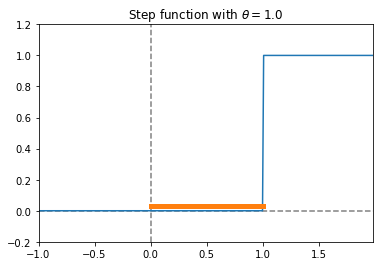

In [3]:
theta = 1
x = np.arange(-100, 200)/100.0
y = [0 if j <= theta else 1 for j in x]
ymin, ymax = (-0.2, 1.2)
xmin = np.min(x)
xmax = np.max(x)
plt.axis([xmin, xmax, ymin, ymax])
plt.plot([0, 0], [ymin, ymax], "--", color="grey")
plt.plot([xmin, xmax], [0, 0], "--", color="grey")
plt.plot(x, y)
plt.plot([0, 1], [0.03, 0.03], "-", linewidth=5)
plt.title(r"Step function with $\theta = %.1f$" % (theta,))
plt.savefig("figures/step.png")
plt.show()

## Creating Logical Gates with MP Neurons

McCullogh & Pitt wanted to demonstrate that their simple neuronal model could be used to similate the computations of digital computers. For that reason, they showed that it can be used to create simple _logical gates_, such as AND and OR functions.

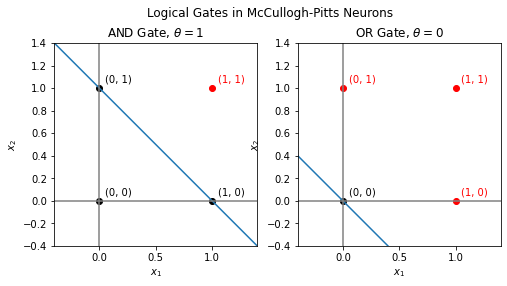

In [4]:
x = np.arange(-100, 200)/100.0
y1 = -x + 1.025
y2 = -x + 0.025
limits = (-0.4, 1.4)

x1_values = [0, 0, 1, 1]
x2_values = [0, 1, 0, 1]

fig, axs = plt.subplots(1,2, figsize=(8, 4))
fig.suptitle("Logical Gates in McCullogh-Pitts Neurons")

for i, theta in enumerate([1, 0]):
    y = -x + theta
    axs[i].set(xlim=limits, ylim=limits)
    axs[i].plot(y, x, "-", label = r"OR Gate, $\theta = 0$")
    axs[i].plot([0, 0], limits, color="grey")
    axs[i].plot(limits, [0, 0], color="grey")
    
    gate = "OR"
    if theta == 1:
        gate = "AND"
    
    for x1, x2 in zip(x1_values, x2_values):
        col = "r" if x1 + x2 > theta else "k"
        axs[i].scatter([x1], [x2], marker="o", color= col)
        axs[i].annotate("(%s, %s)" % (x1, x2), 
                        (x1 + 0.05, x2+0.05),
                        color = col)
        
    axs[i].set_title(r"%s Gate, $\theta = %d$" % (gate, theta))
    axs[i].set_xlabel(r"$x_1$")
    axs[i].set_ylabel(r"$x_2$")
    axs[i].set_aspect('equal')

plt.savefig("figures/mp-logical.png")
plt.show()

## The Bird Brain network

Now, with this system in place, we can create our simplest network ever: A tiny __bird brain__ that either eats, or doesn't eat, the input object depending on its fatures.

Our bird hastwo input neurons:

1. A `neuron_circle` neuron encoding whether the object we are looking at is a circle,
2. A `neural_small` neuron encoding whether the object we are looking at is small

The goal is to modify the neuron's threshold to respond only to objects that are both small and round.  


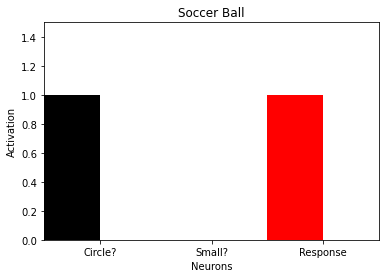

In [5]:
# Input neurons
neuron_circle = 0
neuron_small = 0

# Internal threshold
theta = 0

# Plot title (ignore!)
title = ""

# A few sample stimuli
berry = {"name" : "Berry", "value" : [1, 1]}
cat = {"name" : "Cat", "value" : [0, 0]}
rock = {"name" : "Rock", "value" : [0, 1]}
soccerball = {"name" : "Soccer Ball", "value" : [1, 0]}

def step( x ):
    """Step function"""
    if x >= theta:
        return 1
    else:
        return 0
        
def response():
    """Response of detector neuron"""
    return step( neuron_circle + neuron_small )

def apply_stimulus(stim):
    """Applies one of the stimuli"""
    global neuron_circle
    global neuron_small
    global title
    neuron_circle = stim["value"][0]
    neuron_small = stim["value"][1]    
    title = stim["name"]

apply_stimulus(soccerball)

# Plot the results
fig, ax = plt.subplots()
ax.axis([-0.5, 2.5, 0, 1.5])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["Circle?", "Small?", "Response"])
ax.set_ylabel("Activation")
ax.set_xlabel("Neurons")
ax.bar(np.arange(2) - 0.25, [neuron_circle, neuron_small], 0.5, color='black')
ax.bar(1.75, response(), 0.5, color='red')
ax.set_title(title)

plt.show()

# Perceptrons 

Perceptrons use linear activation functions.

## Learning Synapses: Gradient descent

Neural networks use _synaptic weights_ to scale the effects of their inputs. Thus, the full activation function looks like this 

$$
y_i = f(\sum_j w_{j,i}x_j - \theta)
$$



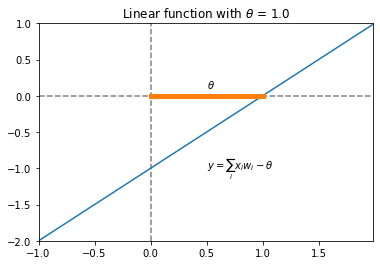

In [6]:
theta = 1
x = np.arange(-100, 200)/100.0
y = [j - theta for j in x]
ymin, ymax = (-2, 1)
xmin = np.min(x)
xmax = np.max(x)
plt.axis([xmin, xmax, ymin, ymax])
plt.plot([0, 0], [ymin, ymax], "--", color="grey")
plt.plot([xmin, xmax], [0, 0], "--", color="grey")
plt.plot(x, y)
plt.plot([0, theta], [0, 0], "-", linewidth=5)
plt.text(x=theta/2, y=0.1, s=r"$\theta$")
plt.text(x=theta/2, y=-1, s=r"$y = \sum_i x_i w_i - \theta$")
plt.title(r"Linear function with $\theta$ = %.1f" % (theta,))
plt.savefig("figures/linear.png")
plt.show()

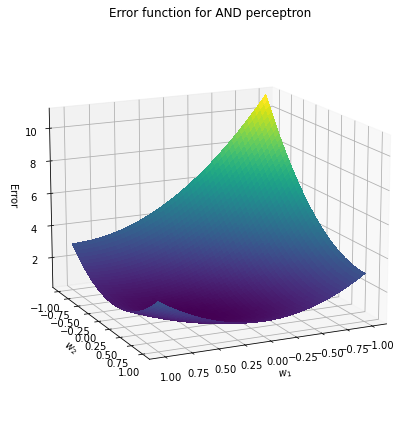

In [7]:
w1 = np.linspace(-1, 1, 100)
w2 = np.linspace(-1, 1, 100)
inputs = [(0,0), (0,1), (1,0), (1,1)]
targets = [0,0,0,1]
            
def perceptron_error(x, y):
    "Error function for AND perceptron"
    err = 0.
    for inpt, trgt in zip(inputs, targets):
        err += (x * inpt[0] + y * inpt[1] - trgt)**2
    return err

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(w1, w2)
Z = perceptron_error(X, Y)
ax.plot_surface(X, Y, Z, cmap="viridis", antialiased=False)
ax.set_xlabel(r"$w_1$")
ax.set_ylabel(r"$w_2$")
ax.set_zlabel("Error")
ax.set_title("Error function for AND perceptron")
ax.view_init(15, 65)
fig.tight_layout()
plt.savefig("figures/error_surface_2d.png")

Gradient descent is performed by calculating the following derivative:

$$
\frac{\partial E}{\partial w_j} = \frac{\partial E}{\partial y} \times \frac{\partial y}{\partial w_j} 
$$

which is the product of two separate terms, which can be calculated separately. The first term can be simplified this way:

$$
\begin{aligned}
\frac{\partial E}{\partial y} &= \frac{\partial \frac{1}{2} [y - t(p)]^2}{\partial y} \\
&= -[t(p) - y]
\end{aligned}
$$

The second term, on the other hand, simply reduces to the corresponding input $x_j$

$$
\begin{aligned}
\frac{\partial y}{\partial w_j} &= \frac{\partial \sum_j w_j x_j}{\partial w_j} \\
&= x_j
\end{aligned}
$$

And therefore:
$$
\frac{\partial E}{\partial w_j} = [y - t(p)] \times x_j
$$

In [8]:
w1 = -1
w2 = -1
eta = 0.05
E = np.zeros((50, 3))
for i in range(50):
    err = 0.
    for inpt, trgt in zip(inputs, targets):
        y = (w1 * inpt[0] + w2 * inpt[1])
        err += (y - trgt)**2
    E[i,] = (w1, w2, err)
    
    for inpt, trgt in zip(inputs, targets):
        x1, x2 = inpt
        y = x1 * w1 + x2 * w2
        delta = y - trgt
        
        w1 -= delta * x1 * eta
        w2 -= delta * x2 * eta

# Final responses
responses = []
for inpt, trgt in zip(inputs, targets):
    x1, x2 = inpt
    y = x1 * w1 + x2 * w2
    responses.append(y)

We can now visualize the changes in synapses and error as a function of the epoch

In [1]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))
ylabels = [r"$w_1$", r"$w_2$", r"$E$"]
for j, ax in enumerate(axs[0:3]):
    ax.plot(E[:,j])
    ax.set_xlabel("Epoch")
    ax.set_xlim(0, 50)
    ax.set_title(ylabels[j])
    ax.hlines(xmin=-100, xmax=100, y=0, color="grey", linestyle="-")
fig.suptitle("Changes in synaptic weights and error during learning")
fig.tight_layout()

## Show the responses.

#fig, ax = plt.subplots()
ax = axs[3]
ax.axis([-0.5, 3.5, -0.1, 1.1])
ax.set_xticks(np.arange(len(inputs)))
ax.set_xticklabels(["%s" % (x,) for x in inputs])
ax.set_ylabel("Response")
ax.set_xlabel("Inputs")
ax.hlines(xmin=-100, xmax=100, y=0, color="grey")
ax.hlines(xmin=-100, xmax=100, y=0.5, color="grey", linestyle="--")
ax.bar(np.arange(len(inputs)), responses)
ax.plot(targets, marker="o", color="red", linestyle="")
ax.set_title("Final Responses")

plt.savefig("figures/learning_perceptron_AND.png")
plt.show()

NameError: name 'plt' is not defined

We can see that, as the network is learning, the synaptic weights are changing in the direction of the steepest descent on the error surface.

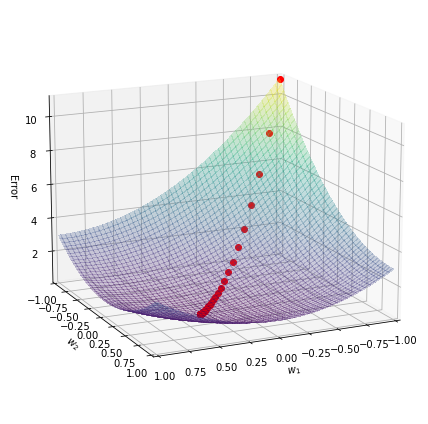

In [10]:
#plt.plot(E[:,2])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap="viridis", antialiased=False, alpha=.25)
ax.plot(E[:,0], E[:,1], E[:,2], color="r", linestyle="", marker="o")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel(r"$w_1$")
ax.set_ylabel(r"$w_2$")
ax.set_zlabel("Error")
ax.view_init(15, 65)
fig.tight_layout()
plt.savefig("figures/error_surface_2d_learning.png")
plt.show()

## An example: Single-digit recognition

As an example, we will learn how to create neurons that recognize simple numbers

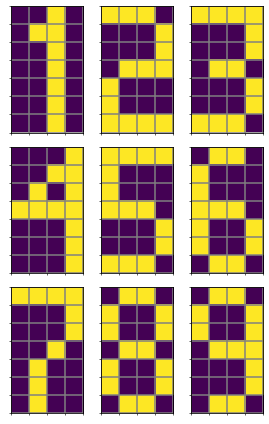

In [11]:
def show_digit(digit, ax=ax):
    num = np.loadtxt("%d.txt" % digit)  # Load the corresponding file , 1...9.txt
    ax.imshow(num, interpolation="None")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticks(np.arange(-.5, 4, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 7, 1), minor=True)
    ax.grid(which='minor', color='grey', linestyle='-', linewidth=1.5)
    
fig, axs = plt.subplots(3, 3, figsize=(4, 6))
for j in range(9):
    c = j % 3
    r = math.floor(j / 3)
    #print((c,r))
    show_digit((j + 1), axs[r,c])
fig.tight_layout()
plt.savefig("figures/digits.png")
plt.show()


We will start with a single neuron that recognizes the number 7. The neuron uses a linar activation function. Its input values are stored in 28-element vector called `x`. The synapses are stored in a randomly initialized vector `w` 

For each input value $ i \in 1..9$, the error function is defined as follows:

$$
E_i = \begin{cases} \frac{1}{2} (1 - y_i)^2 ~ \mathrm{if} ~ i = 7 \\
\frac{1}{2} (0 - y_i)^2 ~\mathrm{if} ~ i \ne 7 
\end{cases}
$$



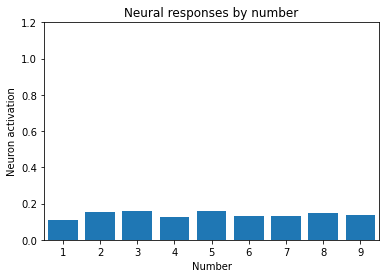

In [12]:
num = np.loadtxt("7.txt")
x = np.zeros((num.size))            # Input values
w = np.random.random(num.size) / 50   # Synapses
eta = 0.01  # Learning rate

def set_inputs(digit):
    """Loads the inputs corresponding to a digit into the input values"""
    global x
    if digit >= 1 and digit < 10:
        x = np.loadtxt("%s.txt" % digit).flatten()
        
def activation():
    """Linear activation rule"""
    inputs = w * x
    return sum(inputs)

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()

vals = np.arange(1, 10)
ys = [calculate_response(j) for j in vals]
plt.axis([0.5, 9.5, 0, 1.2])
plt.bar(vals, ys)
plt.title("Neural responses by number")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

Now, we can implement the gradient descent function.

In [13]:
target_num = 7  # Targer number

def target(i):
    """Desired response function, t(p)"""
    if i == target_num:
        return 1.0
    else:
        return 0.0

def error(i, response):
    """Calculates the error function"""
    return 0.5 * ((target(i) - response) ** 2)
    
def gradient_descent(n = 1):
    """Performs the gradient descent algorithm over N epochs"""
    global w
    for i in np.arange(n):
        dw = np.zeros((num.shape)).flatten()  # General dW = 0.
        e = 0.0 
        for j in vals:  # For every number in our set
            y = calculate_response(j)
            e += error(j, y)  # Calculate the error
            dwj = x * (target(j) - y)
            dwj = dwj / len(vals)   # Increments dW with this number's results
            dw += dwj 
        
        E.append(e)
        w += eta * dw  # updates W

Now, let's pick a target number to learn, `target_num`, and learn:

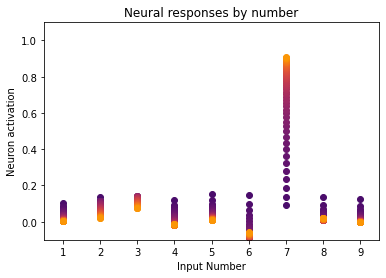

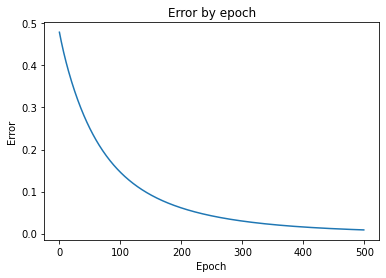

In [14]:
target_num = 7
E = []  # Error by epoch

w = np.random.random(num.size)/50   # Synapses

ys_start = [calculate_response(j) for j in vals]
ys_end = [ys_start]
plt.axis([0.5, 9.5, -0.1, 1.1])
#plt.plot(vals, ys_start, "bo-")

jet = cm = plt.get_cmap('inferno') 
cNorm  = colors.Normalize(vmin = -20, vmax = 70)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

for jj in range(50):
    gradient_descent(n = 10)
    ys_end.append([calculate_response(j) for j in vals])
    
for jj in range(50):
    color = "#0000FF"
    alpha = hex(jj * 10)
    alpha = alpha[2:]
    if len(alpha) < 2:
        alpha = "0" + alpha
    plt.plot(vals, ys_end[jj], color=scalarMap.to_rgba(jj), marker="o", linestyle="")
    
plt.title("Neural responses by number")
plt.xlabel("Input Number")
plt.ylabel("Neuron activation")
plt.savefig("figures/response_changes_7.png")
plt.show()

plt.plot(E)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error by epoch")
plt.savefig("figures/error_7.png")
plt.show()

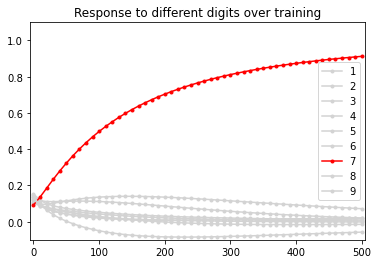

In [15]:
ys = np.array(ys_end)
plt.axis([-0.5, 50.5, -0.1, 1.1])
ticks = [0, 10, 20, 30, 40, 50]
plt.xticks(ticks, labels=[x*10 for x in ticks])
for j in range(9):
    if (j == 6):
        plt.plot(ys[:,j], color="red", marker=".")
    else:
        plt.plot(ys[:,j], color="lightgrey", marker=".")
plt.title("Response to different digits over training")
plt.legend(labels=[x + 1 for x in range(9)])
plt.savefig("figures/response_changes_7_curves.png")

## Examining the synaptic weights

To understand neural networks, it is common to examine the synaptic weights. This will be fundamental as networks get more complicated. 


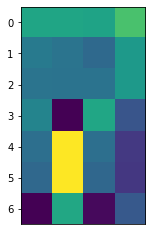

Response: 0.9124797358192253


In [16]:
res = np.reshape(w, (7,4))
plt.imshow(res)
#plt.title("Synaptic weights when target number is %s" % target_num)
plt.xticks([])
set_inputs(1)
plt.show()
r = calculate_response(target_num)
print("Response: %s" % r)

# Multi-digit classifier 

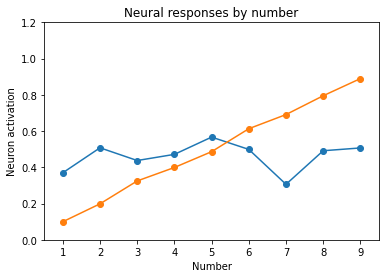

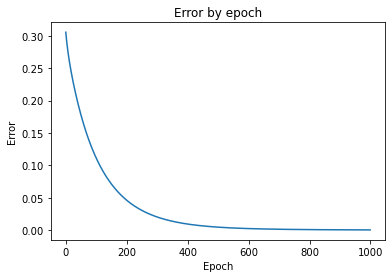

In [17]:
def target(i):
    """New desired response function"""
    return i/10.0

E = []  # Error by epoch

w = np.random.random(num.size)/10   # Synapses

ys_start = [calculate_response(j) for j in vals]

plt.axis([0.5, 9.5, 0, 1.2])
plt.plot(vals, ys_start, "-o")

gradient_descent(n = 1000)

ys_end = [calculate_response(j) for j in vals]
plt.plot(vals, ys_end, "-o")
plt.title("Neural responses by number")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

plt.plot(E)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error by epoch")
plt.show()

### Multiple response unit solution

Another solution, a bit more complicated, requires modifying the network so that our 28 input units are mapped to 9 output units, one for each number 1..9. In turn, this requires defining the synaptic layer as a 28x9 matrix between 28 input units and 9 response units. 

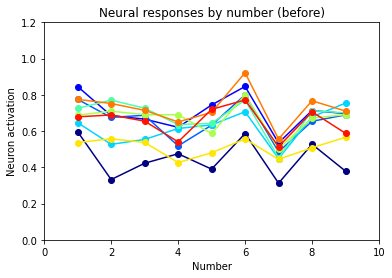

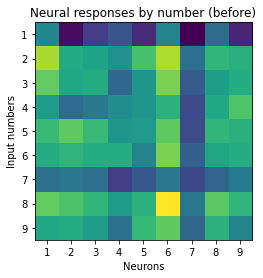

ValueError: operands could not be broadcast together with shapes (28,) (1,9) 

In [19]:
w = np.random.random((num.size, 9)) / 10   # Synapses

def activation():
    """Linear activation rule"""
    z = x.reshape((1, 28))
    inputs = z.dot(w)
    return inputs

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()


def target(i):
    """Desired response function, t(p)"""
    z = np.zeros((9))
    z[i-1] = 1
    return z
    
def error(i, response):
    """Calculates the error function"""
    return 0.5 * np.sum(((target(i) - response) ** 2))

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin = 0, vmax = len(vals))
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

E = []  # Error by epoch

for j in vals:
    ys = calculate_response(j)
    plt.plot(vals, ys.reshape(9).tolist(), "o-", color=scalarMap.to_rgba(j-1))
    
plt.axis([0,10,0,1.2])
plt.title("Neural responses by number (before)")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

ys = np.zeros((9,9))
for j in vals:
    y = calculate_response(j)
    ys[j-1] = y
    
plt.imshow(ys, interpolation="none")
plt.title("Neural responses by number (before)")
plt.xlabel("Neurons")
plt.ylabel("Input numbers")
plt.xlabel("Neurons")
plt.xticks(vals -1, vals)
plt.ylabel("Input numbers")
plt.yticks(vals -1, vals)
plt.show()

gradient_descent(n = 2000)

for j in vals:
    ys = calculate_response(j)
    plt.plot(vals, ys.reshape(9).tolist(), "o-", color=scalarMap.to_rgba(j-1))
    
plt.axis([0,10,0,1.2])
plt.title("Neural responses by number (before)")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

plt.plot(E)
plt.title("Error by epoch")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

ys = np.zeros((9,9))
for j in vals:
    y = calculate_response(j)
    ys[j-1] = y
    
plt.imshow(ys, interpolation='none')
plt.title("Neural responses by number (after)")
plt.xlabel("Neurons")
plt.xticks(vals -1, vals)
plt.ylabel("Input numbers")
plt.yticks(vals -1, vals)
plt.show()

### A Realistic Example: MNIST

We will use the amazing version of the database created by Joseph Chet Redmon (https://pjreddie.com/).

In [ ]:
df = pd.read_csv("mnist_train.csv")
mnist = np.array(df)

mnist_samples = []
mnist_nums = []

for i in range(100):
    num = mnist[i+100, 0]
    if not num in mnist_nums:
        mnist_nums.append(num)
        mnist_samples.append(mnist[i+100, 1:])

mnistset = dict(zip(mnist_nums, 
                    mnist_samples))

fig, axs = plt.subplots(2, 5, figsize=(5, 2))

for i in range(10):
    sample = mnistset[i].reshape((28, 28))

    # Get axes coordinates
    r = math.floor(i / 5)
    c = i % 5
    ax = axs[r, c]
    
    # Show digit
    ax.imshow(sample, vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.tight_layout()

## Problems with perceptrons

Let's try to create a network that can perform a XOR logical operation (XOR gate). The network has two input units, $x_1$ and $x_2$, both of which can take the values 0 and 1. The response of the output neuron $y$ should be $y = 1$ when its inputs are $(1, 0)$ or $(0, 1)$, and $y = 0$ when its inputs are $(1, 1)$ or $(0, 0)$

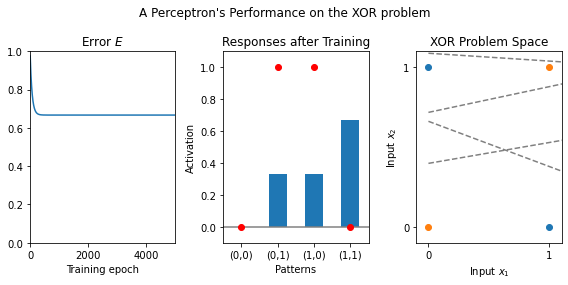

In [63]:
x = np.zeros((2))            # Input values
w = np.random.random((2)) / 10   # Synapses
eta = 0.01  # Learning rate

E = []

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

def set_inputs(vals):
    """Loads the inputs corresponding to a digit into the input values"""
    global x
    x = np.array(vals)
    
def activation():
    """Linear activation rule"""
    inputs = w * x
    return sum(inputs)

def target(val):
    """Desired response function, t(p)"""
    if  np.all(val == np.array([0, 1])) or np.all(val == np.array([1, 0])):
        return 1.0
    else:
        return 0.0
    
def gradient_descent(n = 1):
    """Performs the gradient descent algorithm over N epochs"""
    global w
    for i in np.arange(n):
        dw = np.zeros((2))  # General dW = 0.
        e = 0.0 
        for j in patterns:  # For every number in our set
            y = calculate_response(j)
            e += error(j, y)  # Calculate the error
            dwj = x * (target(j) - y)
            dwj = dwj / len(patterns)   # Increments dW with this number's results
            dw += dwj 
        
        E.append(e)
        w += eta * dw  # updates W

# Plot the problem space

fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(8, 4))

        
# Results of training

n_epochs = 5000        
gradient_descent(n_epochs)
ax1.axis([0, n_epochs, 0, 1])
ax1.set_xlabel("Training epoch")
ax1.set_title("Error $E$")
ax1.plot(E)

# Plot the responses after training

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
ax2.axis([-0.5, 3.5, -0.1, 1.1])
ax2.set_xticks(np.arange(4))
ax2.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax2.set_ylabel("Activation")
ax2.set_xlabel("Patterns")
ax2.bar(np.arange(4), y_end, 0.5)
ax2.hlines(xmin=-100, xmax=100, y=0, color="grey")
ax2.plot([target(p) for p in patterns], marker="o", color="red", linestyle="")
ax2.set_title("Responses after Training")

ax3.plot([0, 1], [1, 0], 'o')
ax3.plot([0, 1], [0, 1], 'o')
ax3.axis([-0.1, 1.1, -0.1, 1.1])
ax3.set_xlabel("Input $x_1$")
ax3.set_xticks([0, 1])
ax3.set_ylabel("Input $x_2$")
ax3.set_yticks([0, 1])
ax3.set_title("XOR Problem Space")

# Draw random lines
import random
X = np.linspace(0,1)
for i in range(6):
    a = random.uniform(-0.5, 1.5)
    b = random.uniform(-15, 15)
    y = a + b*X
    ax3.plot(y, "--", color="grey")
    
fig.suptitle("A Perceptron's Performance on the XOR problem")
fig.tight_layout()
plt.savefig("figures/xor_perceptron.png")
plt.show()